In [2]:
from pyspark.sql import SparkSession, Window, DataFrame

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Initialize Spark session
spark = (SparkSession.builder.appName("DataProcessingApp")
         .config("spark.executor.memory", "8g")
         .config("spark.driver.memory", "8g")
         .config("spark.driver.maxResultSize", "4g")
         .getOrCreate())
spark.sparkContext.setLogLevel("DEBUG")

# Read the CSV file into a DataFrame
df = spark.read.csv('../data/US_Accidents_March23_cleaned.csv', header=True, inferSchema=True)
df.show(5)

+---+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+--------------+---------------+----------+-----+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|        Street|           City|    County|State|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Sig

In [3]:
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, hour, minute

# Convert Start_Time to timestamp (if not already)
df = df.withColumn("Start_Time", col("Start_Time").cast("timestamp"))

df = df.withColumn("Year", year(col("Start_Time"))).withColumn("Month", month(col("Start_Time"))).withColumn("Weekday", dayofweek(col("Start_Time")).cast("int") - 2).withColumn("Day", dayofmonth(col("Start_Time")))

# Extract hour and minute
df = df.withColumn("Hour", hour(col("Start_Time"))) \
       .withColumn("Minute", minute(col("Start_Time")))
df.show(5)

+---+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+--------------+---------------+----------+-----+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----+-------+---+----+------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|        Street|           City|    County|State|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Statio

In [4]:
features_to_drop = ["ID", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Street", "County", "Zipcode", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
df = df.drop(*features_to_drop)
df.show(5)

+--------+------------------+-------------------+------------+---------------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+--------------+----+-----+-------+---+----+------+
|Severity|         Start_Lat|          Start_Lng|Distance(mi)|           City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Civil_Twilight|Year|Month|Weekday|Day|Hour|Minute|
+--------+------------------+-------------------+------------+---------------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-----

In [5]:
df = df.drop_duplicates()

In [6]:
from pyspark.sql.functions import col, mean

# List of columns to fill with mean
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

# Fill missing values with mean for specified columns
for feature in features_to_fill:
    mean_value = df.select(mean(col(feature))).collect()[0][0]
    df = df.fillna({feature: mean_value})

# Drop rows with any remaining missing values
df = df.dropna()
df.show(5)

+--------+------------------+------------------+------------------+------------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+--------------+----+-----+-------+---+----+------+
|Severity|         Start_Lat|         Start_Lng|      Distance(mi)|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Civil_Twilight|Year|Month|Weekday|Day|Hour|Minute|
+--------+------------------+------------------+------------------+------------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------

In [7]:
from pyspark.sql.functions import count, when

df.select([count(when(col(c).isNull(), 1)).alias(f"{c}_null_count") for c in df.columns]).show()

+-------------------+--------------------+--------------------+-----------------------+---------------+----------------+-------------------------+----------------------+-----------------------+-------------------------+-------------------------+--------------------------+----------------------------+----------------------------+------------------+---------------+-------------------+-------------------+-------------------+------------------+------------------+---------------------+------------------+---------------+--------------------------+-------------------------+-------------------------+---------------+----------------+------------------+--------------+---------------+-----------------+
|Severity_null_count|Start_Lat_null_count|Start_Lng_null_count|Distance(mi)_null_count|City_null_count|State_null_count|Temperature(F)_null_count|Humidity(%)_null_count|Pressure(in)_null_count|Visibility(mi)_null_count|Wind_Direction_null_count|Wind_Speed(mph)_null_count|Precipitation(in)_null_coun

In [8]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+----------+-------+------------------+------------------+------------------+-----------------+--------------+------------------+--------------------+-----------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|          Severity|        Start_Lat|         Start_Lng|      Distance(mi)|      City|  State|    Temperature(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|Wind_Direction|   Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Civil_Twilight|              Year|             Month|           Weekday|               Day|              Hour|            Minute|
+-------+------------------+-----------------+------------------+------------------+----------+-------+------------------+------------------+------------------+-----------------+--------------+------------------+--------------------+-----

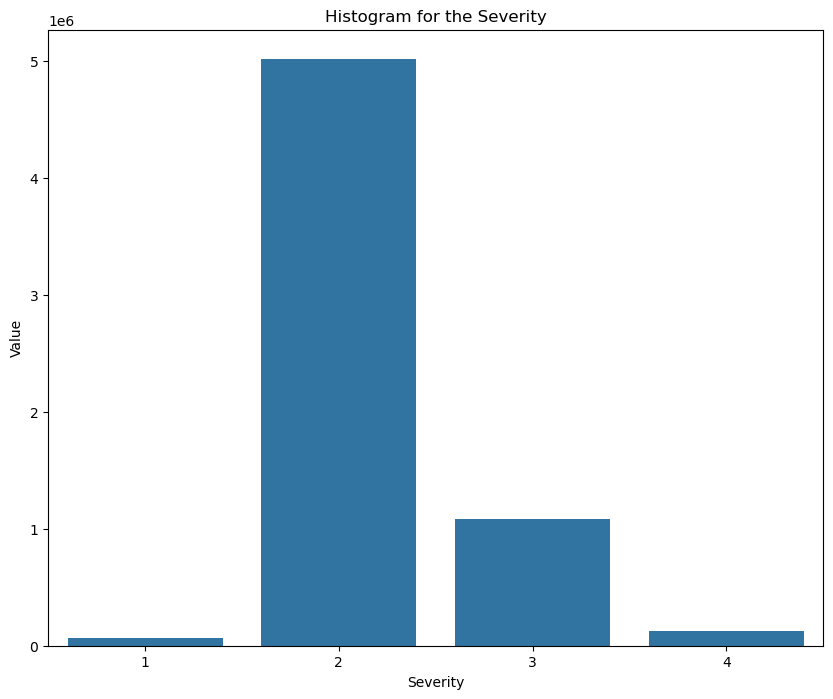

In [9]:
# Calculate the severity counts
severity_counts = df.groupBy("Severity").count().orderBy("Severity")

# Convert to Pandas DataFrame for visualization
severity_counts_pd = severity_counts.toPandas()

# Plot using Seaborn and Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.title("Histogram for the Severity")
sns.barplot(x=severity_counts_pd["Severity"], y=severity_counts_pd["count"])
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [10]:
from pyspark.sql.functions import rand, row_number
from pyspark.sql.window import Window

# Step 1: Determine the sample size for Severity == 1
size = df.filter(col("Severity") == 1).count()

# Step 2: Define a window specification to create row numbers within each severity group
window_spec = Window.partitionBy("Severity").orderBy(rand())  # Randomize the row numbers

# Step 3: Add a row number column and filter rows based on the sample size
df_with_row_number = df.withColumn("row_num", row_number().over(window_spec))

# Step 4: Filter rows to only include those with row numbers less than or equal to the sample size
balanced_df = df_with_row_number.filter(col("row_num") <= size).drop("row_num")

balanced_df.show(5)

+--------+-----------------+-------------------+------------------+----------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+--------------+----+-----+-------+---+----+------+
|Severity|        Start_Lat|          Start_Lng|      Distance(mi)|      City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Civil_Twilight|Year|Month|Weekday|Day|Hour|Minute|
+--------+-----------------+-------------------+------------------+----------+-----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-----

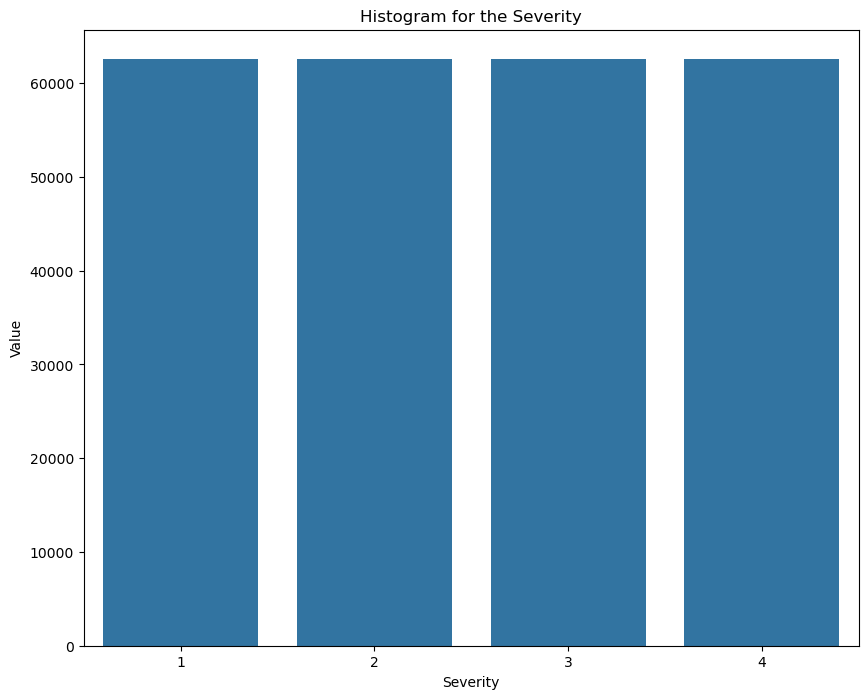

In [12]:
# Calculate the severity counts
severity_counts = balanced_df.groupBy("Severity").count().orderBy("Severity")
severity_counts_pd = severity_counts.toPandas()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the Severity")
sns.barplot(x=severity_counts_pd["Severity"], y=severity_counts_pd["count"])
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [18]:
df = balanced_df

In [19]:
df.toPandas().to_csv('../data/US_Accidents_March23_balanced.csv', index=False)